In [112]:
def generate_xyz_trajectory(
    x0, y0, z0,
    vx0, vy0, vz0,
    ax0, ay0, az0,
    num_points, dt
):
    '''
    Simulate constant acceleration trajectory.
    Add noise to the output to simulate measurements.
    '''
    x, y, z = [x0], [y0], [z0]

    # Generate raw points
    for n in range(1, num_points):
        t = n * dt

        x.append( x0 + vx0*t + ax0*(t**2)/2 )
        y.append( y0 + vy0*t + ay0*(t**2)/2 )
        z.append( z0 + vz0*t + az0*(t**2)/2 )

    return x, y, z

import numpy as np
def add_noise(
    a, b, c,
    stds, mean=0
    ):
    
    sz = len(a)
    gaussian_noise = np.random.default_rng().normal(loc=mean, scale=stds[0], size=sz)
    a_n = a + gaussian_noise
    gaussian_noise = np.random.default_rng().normal(loc=mean, scale=stds[1], size=sz)
    b_n = b + gaussian_noise
    gaussian_noise = np.random.default_rng().normal(loc=mean, scale=stds[2], size=sz)
    c_n = c + gaussian_noise

    return a_n, b_n, c_n

import matplotlib.pyplot as plt
def plot_trajectory_1d(timestamps, data):
    if (len(timestamps) != len(data)):
        print('plot_trajectory_1d(): '\
              f'expected matching input lengths, got {len(timestamps)}, {len(data)} instead.')
        return None
    plt.plot(timestamps, data)
    plt.xlabel('Time')
    plt.ylabel('Coord')
    plt.show()

def plot_trajectory_3d(x, y, z):
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(x, y, z)
    plt.show()

def plot_filtering_results_1d(x_pred, z, timestamps, x_true=None):
    fig, ax = plt.subplots(nrows=1, ncols=2)

    if x_true:
        ax[0].plot(timestamps, x_true, label='Истинные значения')
        ax[1].plot(timestamps, x_true - x_pred, label='Разница м/ду истиной и предсказанием')

    ax[0].plot(timestamps, x_pred, color='r', label='Предсказания фильтра')
    ax[0].scatter(timestamps, z, color='k', label='Измерения')

    plt.legend()
    plt.show()
    

import numpy as np
def xyz_to_sphere(X, Y, Z):
    r, u, v = [], [], []
    for x, y, z in zip(X, Y, Z):
        r.append( np.sqrt(x**2 + y**2 + z**2) )
        u.append( np.arctan2(y, x) )
        v.append( np.arctan2(z, np.sqrt(x**2 + y**2)) )

    return r, u, v

def sphere_to_xyz(R, U, V):
    x, y, z = [], [], []
    for r, u, v in zip(R, U, V):
        x.append( r*np.cos(v)*np.cos(u) )
        y.append( r*np.cos(v)*np.sin(u) )
        z.append( r*np.sin(v) )
 
    return x, y, z

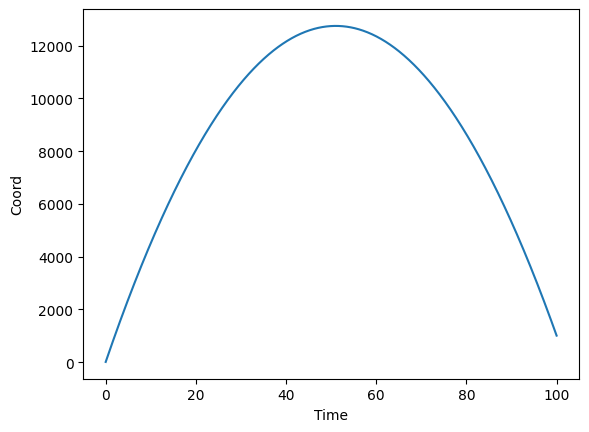

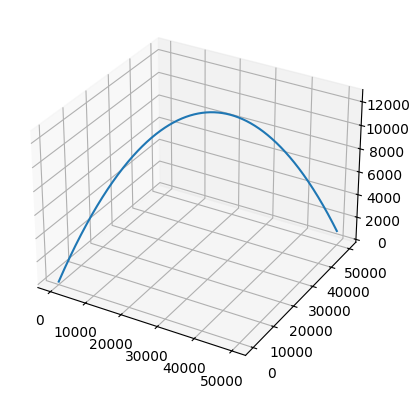

In [66]:
import numpy as np
x, y, z = generate_xyz_trajectory(
    10, 10, 10,
    500, 500, 500,
    0, 0, -9.81,
    1000, 0.1)

t = np.linspace(0, 1000*0.1, 1000)
plot_trajectory_1d(t, z)
plot_trajectory_3d(x, y, z)

In [54]:
r, u, v = xyz_to_sphere(x, y, z)
r, u, v = add_noise(r, u, v, stds=[50, 0.01, 0.01])

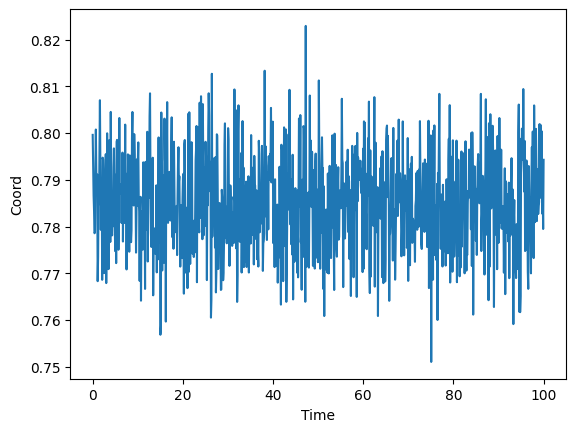

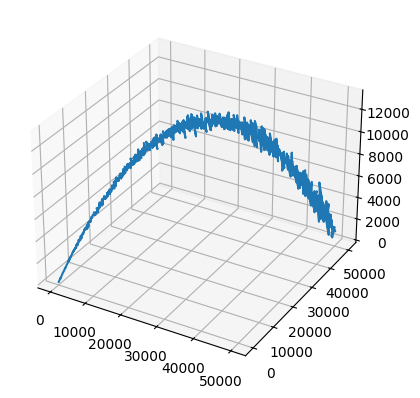

In [67]:
plot_trajectory_1d(t, u)
x_n, y_n, z_n = sphere_to_xyz(r, u, v)
plot_trajectory_3d(x_n, y_n, z_n)

In [95]:
import numpy as np
class KalmanFilter():
    def __init__(self, dim_x, dim_z, dim_u,
                 x0,
                 P, H, F, B, Q, R):
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dim_u = dim_u

        self.x = np.asarray(x0)
        self.u = np.zeros(dim_u)

        self.P = np.asarray(P)
        self.H = np.asarray(H)
        self.F = np.asarray(F)
        self.B = np.asarray(B)
        self.Q = np.asarray(Q)
        self.R = np.asarray(R)
    
    def predict(self, x, P, F, Q, u=[[0]], B=[[0]]):
        x_pred = F@x #+ B@u
        P_pred = F@P@F.T + Q

        return x_pred, P_pred

    def update(self, x, P, H, z, R):
        S = H@P@H.T + R
        S_inv = np.linalg.pinv(S) 
        K = P@H.T@S_inv

        y = z - H@x
        x_est = x + K@y
        I = np.eye(N=self.dim_x)
        P_est = (I - K@H)@P@(I - K@H).T + K@R@K.T

        return x_est, P_est
    
    def batch_filter(self, Z):
        X = []
        for z in Z:
            x, P = self.predict(self.x, self.P, self.F, self.Q)
            x_est, P_est = self.update(x, P, self.H, z, self.R)
            self.x = x_est
            self.P = P_est
            X.append(x_est.tolist()) 

        return np.asarray(X)



In [96]:
dt = 0.1
x0=np.array([0., 0.])
P = np.array([
    [250., 0],
    [0, 100.]
])
H = np.array([
    [1., 0],
])
F = np.array([
    [1., dt],
    [0, 1.]
])
B = np.array([[0]])
Q = np.array([[0.588, 1.175],
            [1.175, 2.35 ]])
R = np.array([
[25,]
])

kf = KalmanFilter(
    dim_x=2,
    dim_z=1,
    dim_u=0,
    x0=x0,
    P=P, H=H, F=F, B=B, Q=Q, R=R
)

In [97]:
x, P = kf.predict(x=x0, P=P,F=F,Q=Q)
kf.update(x, P, H, x_n[0], R)

(array([30.82972867,  1.3693905 ]),
 array([[ 22.74032134,   1.01007636],
        [  1.01007636, 101.89849587]]))

In [98]:
S = H@P@H.T + R
S_inv = np.linalg.pinv(S) 
K = P@H.T@S_inv

y = x[0] - H@x
x_est = x + K@y

I = np.eye(N=2)

In [99]:
S = H@P@H.T + R
S_inv = np.linalg.pinv(S) 
K = P@H.T@S_inv

y = x[0] - H@x
x_est = x + K@y
I = np.eye(2)
P_est = (I - K@H)@P@(I - K@H).T + K@R@K.T

In [100]:
x_out = kf.batch_filter(x_n)
x_out

array([[3.08297287e+01, 1.36939050e+00],
       [6.53390539e+01, 1.86959685e+01],
       [7.35896964e+01, 2.60403281e+01],
       ...,
       [4.95811628e+04, 4.73179933e+02],
       [4.97749975e+04, 6.31256429e+02],
       [4.97709702e+04, 5.58805253e+02]], shape=(1000, 2))

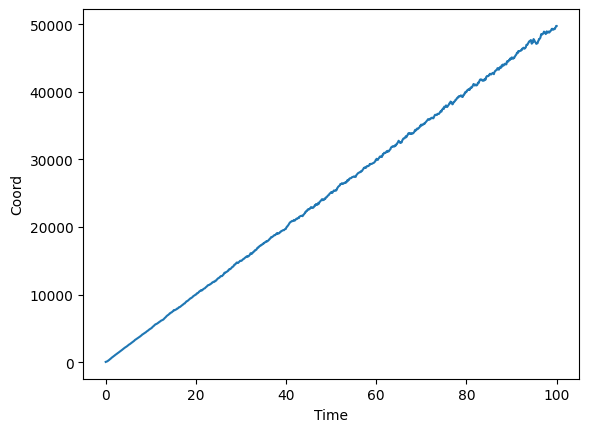

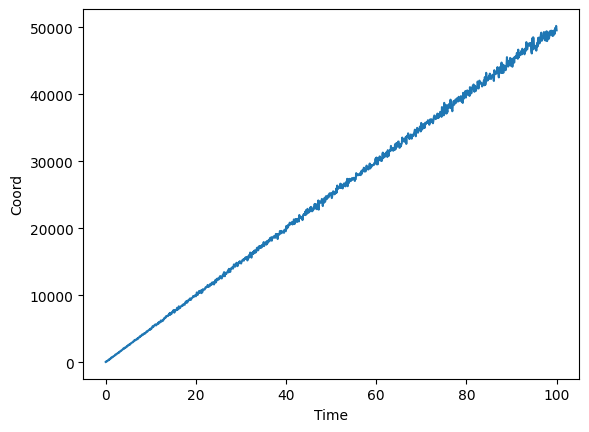

In [103]:
plot_trajectory_1d(t, x_out[:, 0])
plot_trajectory_1d(t, x_n)

/tmp/ipykernel_7569/2045151086.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


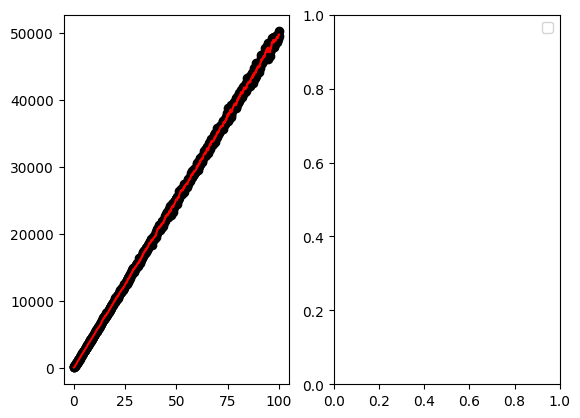

In [113]:
plot_filtering_results_1d(x_out[:, 0], x_n, t)